In [1]:

import os
import glob
import numpy as np
import pandas as pd
import cv2

from sklearn.metrics import confusion_matrix #classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

import keras
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import model_from_json
from keras.models import load_model
from keras.utils.generic_utils import CustomObjectScope

from keras.callbacks import EarlyStopping, TensorBoard

import matplotlib.pyplot as plt
%matplotlib inline  
# for jupyter notebook enviornment. 


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix #classification_report
import itertools  # for confusion matrix plot

from PIL import Image as pil_image


#import tensorflow as tf
#from tensorflow.python.framework import ops
from keras import backend as K

#path = '/python/DDSA/fer/fer2013/'
class_label = ['angry', 'happy','neutral']

n_class = len(class_label)

path = '/python/'  # location
os.chdir(path)

img_size = 48  # fer data size. 48 x 48
target_size = 48 #197 # minimum data size for specific net such as Inception, VGG, ResNet ...

epochs = 30  # n of times of training using entire data
batch_size = 16

import autokeras as ak
import os
import numpy as np
import random
#from autokeras.classifier import load_image_dataset
#os.chdir('/content/drive/tmp/face/') # change directory
print(os.getcwd())


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


F:\python


In [12]:
def plot_hist(hist):
    plt.figure(0)
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(hist.history['acc'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='lower left')

    plt.show()
    plt.savefig('loss_accuracy_plot')
    plt.close()

# Make and plot confusion matrix. To see the detailed imformation about TP, TN of each classes.    
def make_confusion_matrix(model, x, y, normalize = True):
    predicted = model.predict(x)

    pred_list = []; actual_list = []
    for i in predicted:
        pred_list.append(np.argmax(i))
    for i in y:
        actual_list.append(np.argmax(i))

    confusion_result = confusion_matrix(actual_list, pred_list)
    plot_confusion_matrix(confusion_result, classes = class_label, normalize = normalize, title = 'Confusion_matrix')
    return confusion_result

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("normalized")
    else:
        print('without normalization')

    print(cm)
    plt.figure(1)
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Confusion_matrix')
    
def data_arrange(x_data,y_data):
    # data class re-arrange
    
    # Angry vs neutral vs happy case
    x_angry = x_data[y_data==0]
    x_happy = x_data[y_data==3]
    x_neutral = x_data[y_data==6]
    
    y_angry = y_data[y_data==0]
    y_happy = y_data[y_data==3]
    y_neutral = y_data[y_data==6]
    
    # number of happy samples are twice  
    # To avoid class distribution bias. use only 50% sample of happy class
    x_happy_use, x_no, y_happy_use, y_no = train_test_split(x_happy, y_happy, test_size = 0.5, shuffle = True, random_state=33)
    
    #print('Before normalize:{a}\n'.format(a= x_angry[0]))
    xx = np.concatenate((x_angry, x_happy_use, x_neutral),axis=0)/255.0 #concatenate & normalized
    yy = np.concatenate((y_angry, y_happy_use, y_neutral), axis=0)
    yy[yy==3]=1
    yy[yy==6]=2
    
    xx = xx.reshape(-1, img_size,img_size,1)
    #xx = np.stack((xx,)*3, -1 )  # to make fake RGB channel
    yy = np_utils.to_categorical(yy, n_class)
    print('After normalize x:{a} y:{b}\n'.format(a= xx.shape, b=yy.shape))     

    return xx, yy

def sample_plot(x_test, y_test):
    x_angry = x_test[y_test==0]
    a_f = np.squeeze(x_angry[1])
    plt.imshow(a_f, cmap='gray')
    

In [14]:
# data load
os.chdir('/python')
x_data = np.load('./x_data.npy')
y_data = np.load('./y_data.npy')

# 2. arrange the data. shape change, use specific class only, ...
x_data, y_data = data_arrange(x_data, y_data)

# 3. train / test split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, shuffle = True, random_state=33)
#np.shape(x_train)


After normalize x:(18589, 48, 48, 1) y:(18589, 3)



In [8]:
os.chdir('/python/autokeras')
apple = ak.image_classifier.ImageClassifier(verbose = True, searcher_args={'trainer_args':{'max_iter_num':1}}, path = './', resume=True)
searcher = apple.load_searcher()
#searcher.history
#apple.path
best_id = apple.get_best_model_id
print(best_id)
graph = searcher.load_best_model()

loaded_model = graph.produce_keras_model()   # convert model from torch to keras

#graph = searcher.load_best_model()

loaded_model.compile(loss = categorical_crossentropy,
                      optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7),
                      metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_acc', min_delta = 0.001, patience = 20, 
                                       verbose = 1, mode = 'max')
    

<bound method ImageClassifier.get_best_model_id of <autokeras.image_classifier.ImageClassifier object at 0x000000001F73A0F0>>


without normalization
[[  53   49 1201]
 [  26   45 1042]
 [  46   31 1225]]


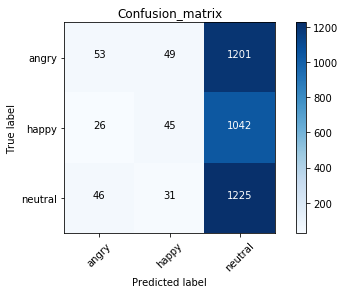

In [16]:
confusion_result = make_confusion_matrix(loaded_model, x_test, y_test, normalize = False) 

In [18]:
loaded_model.save('ak_3class.h5')

In [19]:
hist = loaded_model.fit(x_train, y_train, validation_split = 0.2, shuffle=True, batch_size=16, epochs=30, verbose=1,callbacks = [early_stopping] )
        
scores = loaded_model.evaluate(x_test, y_test, batch_size=16)      


Train on 11896 samples, validate on 2975 samples
Epoch 1/30
11896/11896 [==============================] - 684s 58ms/step - loss: 0.7559 - acc: 0.6725 - val_loss: 0.6308 - val_acc: 0.7294
Epoch 2/30
11896/11896 [==============================] - 760s 64ms/step - loss: 0.6262 - acc: 0.7419 - val_loss: 0.5700 - val_acc: 0.7627
Epoch 3/30
11896/11896 [==============================] - 752s 63ms/step - loss: 0.5696 - acc: 0.7656 - val_loss: 0.5710 - val_acc: 0.7640
Epoch 4/30
11896/11896 [==============================] - 754s 63ms/step - loss: 0.5224 - acc: 0.7851 - val_loss: 0.5319 - val_acc: 0.7788
Epoch 5/30
11896/11896 [==============================] - 754s 63ms/step - loss: 0.4912 - acc: 0.7945 - val_loss: 0.5533 - val_acc: 0.7818
Epoch 6/30
11896/11896 [==============================] - 750s 63ms/step - loss: 0.4649 - acc: 0.8127 - val_loss: 0.5396 - val_acc: 0.7845
Epoch 7/30
11896/11896 [==============================] - 766s 64ms/step - loss: 0.4329 - acc: 0.8254 - val_loss: 0.5

normalized
[[0.77513431 0.04144282 0.18342287]
 [0.09703504 0.80952381 0.09344115]
 [0.11981567 0.07373272 0.80645161]]


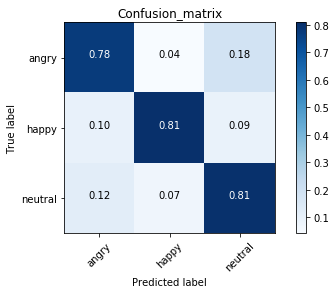

In [20]:
confusion_result = make_confusion_matrix(loaded_model, x_test, y_test, normalize = True) 

In [21]:
loaded_model.save('ak_3-class_trained.h5')

In [22]:
loaded_model.save_weights('ak_3-class_weights.h5')

In [32]:
data_path = '/0GoogleDrive/tmp/cam_face/'
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        data_path+'train',
        target_size=(48, 48),
        batch_size=16, color_mode = 'grayscale',
        class_mode='categorical')#, save_to_dir = './',save_prefix='aug')

validation_generator = test_datagen.flow_from_directory(
        data_path+'validation',
        target_size=(48, 48),
        batch_size=16, color_mode = 'grayscale',
        class_mode='categorical')

early_stopping = EarlyStopping(monitor = 'val_acc', min_delta = 0.001, patience = 20, 
                                       verbose = 1, mode = 'max')

Found 156 images belonging to 3 classes.
Found 58 images belonging to 3 classes.


In [25]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 48, 48, 64)        0         
_________________________________________________________________
activation_5 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 64)        36928     
__________

In [33]:
batch_size=16
hist = loaded_model.fit_generator(
        train_generator,
        steps_per_epoch=30,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=10,callbacks = [early_stopping])

Epoch 1/10
30/30 [==============================] - 23s 776ms/step - loss: 0.2391 - acc: 0.9049 - val_loss: 0.3953 - val_acc: 0.9138
Epoch 2/10
30/30 [==============================] - 23s 771ms/step - loss: 0.1565 - acc: 0.9556 - val_loss: 0.2761 - val_acc: 0.9310
Epoch 3/10
30/30 [==============================] - 23s 768ms/step - loss: 0.0976 - acc: 0.9632 - val_loss: 0.2737 - val_acc: 0.9310
Epoch 4/10
30/30 [==============================] - 23s 768ms/step - loss: 0.0920 - acc: 0.9660 - val_loss: 0.2663 - val_acc: 0.9483
Epoch 5/10
30/30 [==============================] - 23s 777ms/step - loss: 0.0879 - acc: 0.9660 - val_loss: 0.2166 - val_acc: 0.9483
Epoch 6/10
30/30 [==============================] - 23s 772ms/step - loss: 0.0539 - acc: 0.9785 - val_loss: 0.2644 - val_acc: 0.9483
Epoch 7/10
30/30 [==============================] - 23s 768ms/step - loss: 0.0552 - acc: 0.9854 - val_loss: 0.2824 - val_acc: 0.9310
Epoch 8/10
30/30 [==============================] - 23s 765ms/step - 

In [35]:
loaded_model.save('ak_3class_transfer.h5')

normalized
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


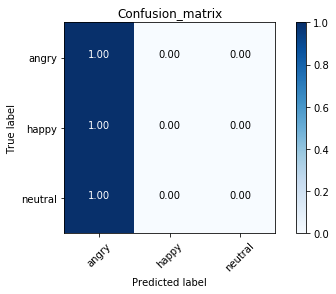

In [34]:
confusion_result = make_confusion_matrix(loaded_model, x_test, y_test, normalize = True) 